# Single-objective Printing Optimization for 3 nominally identical 3D printers case study, Batch 1

### written by Miguel Hernández, Christina Schenk

last updated on 23 Oct 2025

tested on Miguel's Mac, Christina's Mac

This notebook creates suggestions for the batch 1 of the exploration-exploitation phase for performing Bayesian optimization for optimizing printing parameters targeting weight/density.

It involves noise estimation for the noise coming from each of the three nominally identical 3D printers and involving multiple repetitions (sequential and simultaneous) as presented in "Noise-Aware Optimization in Nominally Identical Measuring Systems for High-Throughput Parallel Workflows Manuscript" by Christina Schenk et al. (2025). 

The steps of the workflow are the following:

1. Define design setting
2. Data import and formatting
3. Customizing GP
4. Initialization of the BO parameters
5. BO phase: only 1 suggestion, EI acquisition function, fvGPOptimizer
6. Evaluate results and plot contours
7. Save suggestions to file
8. Capture likelihood and hps output and save metadata

In [1]:
import os, copy
from numpy import arange
from numpy import meshgrid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gpcam.gp_optimizer import GPOptimizer


import random
import sys

import plotly.graph_objects as go

from scipy.stats import norm
from itertools import combinations
import itertools as it

import platform
import yaml
import time
import io
import random

import ast
import re
import math


### Plotting functions

In [2]:
""" Contour plot multiplot for comparison of inputs and outputs for plotting mean, covariance and acquisition.
    
        Parameters
        ----------
        X: input points (where we want to make predictions) first component in grid format
        Y: input points (where we want to make predictions) second component in grid format
        f_mean_re: reshaped posterior mean values
        f_cov_re:reshaped posterior covariance values
        f_acq_re:reshaped acquisition values
        data: data points
        iteration: integer, current iteration number
        figurepath: string for path to folder where plots should be saved
        title1: plot title string, e.g. Posterior mean, 
        title2: plot title string, e.g. Posterior covariance
        title3: plot title string, e.g. Acquisition
        titlexaxis: string of title for xaxis, default x (%)
        titleyaxis: string of title for yaxis, default y (%)
        
        Returns
        -------
        Contour plot multiplot for comparison of inputs and outputs for plotting mean, covariance and acquisition.
        
"""
#contourplot mean, covariance, acquistion function:
def tracking_contourplot_mean_cov_acq(X, Y, f_mean_re, f_cov_re, f_acq_re, data, iteration, figurepath, title1="", title2="", title3="",  titlexaxis="x (%)", titleyaxis="y (%)", batchsize = 1, task=1, taskname = None):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    cp1 = ax[0].contourf(X, Y, f_mean_re)
    cp2 = ax[1].contourf(X, Y, f_cov_re)
    cp3 = ax[2].contourf(X, Y, f_acq_re)
    if data is not None:
        ax[0].scatter(x=data[:, 0], y=data[:, 1])
        ax[0].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[1].scatter(x=data[:, 0], y=data[:, 1])
        ax[1].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[2].scatter(x=data[:, 0], y=data[:, 1])
        ax[2].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
    fig.colorbar(cp1, ax=ax[0])# Add a colorbar to a plot
    fig.colorbar(cp2, ax=ax[1])# Add a colorbar to a plot
    fig.colorbar(cp3, ax=ax[2])# Add a colorbar to a plot
    fig.tight_layout(pad=5.0)
    ax[0].set_title(title1+'\n')
    ax[1].set_title(title2+'\n')
    ax[2].set_title(title3+'\n')
    ax[0].set_ylabel(titleyaxis)
    ax[0].set_xlabel(titlexaxis)
    ax[1].set_ylabel(titleyaxis)
    ax[1].set_xlabel(titlexaxis)
    ax[2].set_ylabel(titleyaxis)
    ax[2].set_xlabel(titlexaxis)
    if taskname:
        fig.suptitle(taskname+'\n', fontsize=20)
    plt.savefig(os.path.join(figurepath,"plot"+str(iteration)+"T"+str(task)+".JPG"))
    plt.show()  
    
    
""" Tracking plot multiplot for comparison of inputs and outputs for plotting mean in one plot and acquisition in another first for x and then for y.
    
        Parameters
        ----------
        x: input points (where we want to make predictions) first component in grid format
        y: input points (where we want to make predictions) second component in grid format
        points: original data plus new sample points
        mean_points: posterior mean at points
        acq_points: acquistion at points
        f_mean: reshaped posterior mean values
        f_acq: reshaped acquisition values
        f_cov:reshaped posterior covariance values
        f_acq_re:reshaped acquisition values
        data: data points, e.g. np.column_stack([points[:,0], points[:,1]]
        iteration: integer, current iteration number
        title1: plot title string, e.g. Posterior mean+covariance
        title2: plot title string, e.g. Acquisition
        batchsize: number of newly generated points, so they are plotted in a different color
        task: number of task for the multitasking case
        taskname: name of the task for the multitasking case
        Returns
        -------
        Tracking plot multiplot for comparison of inputs and outputs for plotting mean in one plot and acquisition in another first for x and then for y.
"""

#contourplot mean, covariance:
def tracking_contourplot_mean_cov(X, Y, f_mean_re, f_cov_re, data, iteration, figurepath, title1="", title2="",  titlexaxis="x (%)", titleyaxis="y (%)", batchsize = 1, task=1, taskname = None):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    cp1 = ax[0].contourf(X, Y, f_mean_re)
    cp2 = ax[1].contourf(X, Y, f_cov_re)
    if data is not None:
        ax[0].scatter(x=data[:, 0], y=data[:, 1])
        ax[0].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[1].scatter(x=data[:, 0], y=data[:, 1])
        ax[1].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
    fig.colorbar(cp1, ax=ax[0])# Add a colorbar to a plot
    fig.colorbar(cp2, ax=ax[1])# Add a colorbar to a plot
    fig.tight_layout(pad=5.0)
    ax[0].set_title(title1+'\n')
    ax[1].set_title(title2+'\n')
    ax[0].set_ylabel(titleyaxis)
    ax[0].set_xlabel(titlexaxis)
    ax[1].set_ylabel(titleyaxis)
    ax[1].set_xlabel(titlexaxis)
    if taskname:
        fig.suptitle(taskname+'\n', fontsize=20)
    plt.savefig(os.path.join(figurepath,"plot"+str(iteration)+"T"+str(task)+".JPG"))
    plt.show()  

### Kernel function

In [3]:
def matern_kernel_diff1(distance, length):
    """
    Function for the matern kernel, order of differentiablity = 1.
    kernel = (1.0 + ((np.sqrt(3.0) * distance) / (length))) * np.exp(
        -(np.sqrt(3.0) * distance) / length

    Parameters
    ----------
    distance : scalar or np.ndarray
        Distance between a set of points.
    length : scalar
        The length scale hyperparameters

    Return
    ------
    A structure of the shape of the distance input parameter : float or np.ndarray
    """

    kernel = (1.0 + ((np.sqrt(3.0) * distance) / (length))) * np.exp(
        -(np.sqrt(3.0) * distance) / length
    )
    return kernel
    
def kernel_mat32_816(x1,x2,hyperparameters):
    """
    Function for the default kernel, a Matern kernel of first-order differentiability.

    Parameters
    ----------
    x1 : np.ndarray
        Numpy array of shape (U x D)
    x2 : np.ndarray
        Numpy array of shape (V x D)
    hyperparameters : np.ndarray
        Array of hyperparameters. For this kernel we need D + 1 hyperparameters
    obj : object instance
        GP object instance.

    Return
    ------
    A structure of the shape of the distance input parameter : float or np.ndarray
    """
    hps = hyperparameters
    distance_matrix = np.zeros((len(x1),len(x2)))
    for i in range(len(x1[0])):
        distance_matrix += abs(np.subtract.outer(x1[:,i],x2[:,i])/hps[1+i])**2
    distance_matrix = np.sqrt(distance_matrix)
    return hps[0] * matern_kernel_diff1(distance_matrix,1)

## 1. Define design setting

In [4]:
#Lower and upper bounds for the parameters:
#speed fixed at 100 and LW at 0.8
f_lb = 1000
f_ub = 5000
lh_lb = 0.2
lh_ub = 0.6

#number of points in x and y direction at which we want to predict:
n_pts = 100

#number of autonomous experiments that you would like to run:
N_exp = 1

#dimension of design space:
dim = 2

n_batch = int(input("Introduce batch number:"))
is_this_a_test = input("Is this a test? y/n")
printer_number = int(input("Introduce printer numer (1-3): "))

Introduce batch number: 1
Is this a test? y/n n
Introduce printer numer (1-3):  1


## 2. Data

Check that the data is the desired one before running the experiment

In [5]:
dataset = "../data/P" + str(printer_number) + "_3printers_Feb2025_data_noise_reformattedtasks_all.xlsx"
df = pd.read_excel(dataset, nrows=225, header=0)
df = df.iloc[:, :7]
df.iloc[:,0] = round(df.iloc[:,0])
df.iloc[:,1] = round(df.iloc[:,1],2)
data_array_expl = np.array(df)

np.save('data/data_exploration.npy', data_array_expl)
data_path = "data"
data_npy = np.load(os.path.join(data_path,"data_exploration.npy"), allow_pickle=True)
points = data_npy[:,0:2]

#Calculate DeltaWs:
volume = 80 * 13 * 3.2 * 1e-3
expected_density = 1.24 #from the PLA datasheet 
#https://www.materialdatacenter.com/ms/en/Ingeo/NatureWorks+LLC/Ingeo%E2%84%A2+3251D/f483c129/5616
expected_weight = volume * expected_density
values = - abs(1-data_npy[:,3+printer_number]/expected_weight)

## 3. Customizing a Gaussian Process

#### Define some points at which we will predict, still has nothing to do with gpCAM 

In [6]:
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.zeros((len(x))) + hps[-1]

In [7]:
my_noise = my_noise

#### Import/Specify kernel that want to use

In [8]:
my_kernel = kernel_mat32_816

#### Define some points at which we will predict, still has nothing to do with gpCAM 

In [9]:
x_pred = np.zeros((n_pts*n_pts,2))
x = np.linspace(f_lb,f_ub,n_pts)
y = np.linspace(lh_lb,lh_ub,n_pts)
X,Y = np.meshgrid(x,y)
counter = 0
for i in  range(n_pts):
    for j in range(n_pts):
        x_pred[counter] = np.array([X[i,j],Y[i,j]])
        counter += 1
x_pred_acq = np.array(list(it.product(np.linspace(f_lb,f_ub,n_pts),np.linspace(lh_lb,lh_ub, n_pts))))

## 4. Initialization of the BO parameters

In [10]:
my_acq_func = "expected improvement"

In [11]:
parameter_bounds = np.array([[f_lb, f_ub],[lh_lb, lh_ub]])
guess1 = 100
guess2 = 1
guess3 = 1
guess4 = 100
guess5 = 0.01

#stat kernel:
hps_guess = np.array([guess1, guess2, guess3, guess5]) #nonstat printid #guess6, guess7,
hps_bounds = np.array([[0.00001,100000.], #signal variance for the kernel
                       [1.,10000.], #length scale 1 for the kernel
                       [0.001,10.], #length scale 2 for the kernel
                       [0.0001,1]  #noise task1
                       ])

## 5. Exploration-Exploitation Phase: EI acquisition function, GPOptimizer

### 5.1 GP Training

In [12]:
start_time  = time.time()
my_gp = GPOptimizer(points, values,
        init_hyperparameters = hps_guess,  # we need enough of those for kernel, noise and prior mean functions
        #hyperparameter_bounds = hps_bounds,
        #noise_variances=vars, # providing noise variances and a noise function will raise a warning 
        #compute_device='cpu',
        #gp_kernel_function=my_kernel,#default for single task is Matern 3/2 kernel
        #gp_kernel_function_grad=None, 
        gp_noise_function=my_noise
        #info=True
        )
#print(my_gp.gp_kernel_function)
print("loglikelihood", my_gp.log_likelihood())
my_gp.train(hyperparameter_bounds=hps_bounds)
print("loglikelihood after", my_gp.log_likelihood())

current_hps = my_gp.get_hyperparameters()
print("hps: ", current_hps)

new_bounds = copy.copy(hps_bounds)
retrain1 = True
retrain2 = True

while retrain1 == True or retrain2 == True:
    if current_hps[1] > 10 * f_ub or current_hps[1] < f_lb / 10.: #6.54984846e+01:
        new_bounds[1][1] = f_ub * 10
        new_bounds[1][0] = f_lb / 10 #From multitask iteration but just evaluation 56.54984846e+01#
        retrain1 = True
    else:
        retrain1 = False
    if current_hps[2] > lh_ub * 10 or current_hps[2] < lh_lb / 10:#: From multitask iteration 57.13930758e+00
        new_bounds[2][1] = lh_ub * 10#7.13930758e+00#
        new_bounds[2][0] = lh_lb / 10
        retrain2 = True
    else:
        retrain2 = False
        

    if retrain1 == True or retrain2 == True:
        my_gp.train(hyperparameter_bounds=new_bounds)
        print("Problematic length scales, re-training")
        print("loglikelihood 2 after", my_gp.log_likelihood())
        current_hps = my_gp.get_hyperparameters()
        print("hps: ", current_hps)

end_time = time.time()
time_ = end_time-start_time

loglikelihood 153.80518378451364
loglikelihood after 372.49856172650027
hps:  [4.23773895e-03 2.69573109e+01 6.07994490e+00 1.49477769e-03]
Problematic length scales, re-training
loglikelihood 2 after 372.2254893050805
hps:  [4.32179209e-03 1.00283143e+02 7.82220414e-02 1.49696999e-03]


### 5.2 Capture likelihood and hps output and save metadata

In [13]:
# Step 1: Capture the printed output
output_capture = io.StringIO()
print_capture = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture(*args, **kwargs, file=output_capture)

# Call the function and capture the output
print(my_gp.log_likelihood())

# Reset print to original function
print = print_capture

# Get the printed value as a string
captured_output = output_capture.getvalue().strip()


# Step 1: Capture the printed output
output_capture_hps = io.StringIO()
print_capture_hps = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture_hps(*args, **kwargs, file=output_capture_hps)

# Call the function and capture the output
print(my_gp.get_hyperparameters())

# Reset print to original function
print = print_capture_hps

# Get the printed value as a string
captured_output_hps = output_capture_hps.getvalue().strip()

### 5.3 BO

kernel <function kernel_mat32_816 at 0x13e707280>
loglikelihood 372.2254893050805
current pts [3.93501636e+03 5.99693088e-01]
current vals [0.02622583]
hps:  [4.32179209e-03 1.00283143e+02 7.82220414e-02 1.49696999e-03]
(10000,)


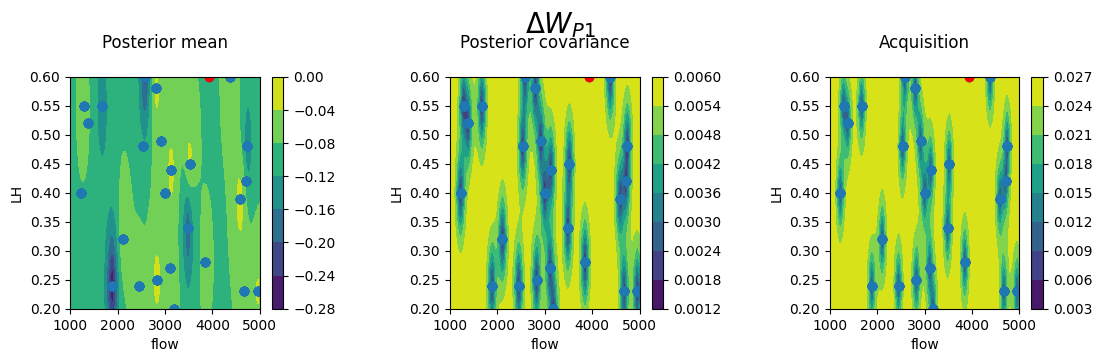

hps:  [4.53392039e-03 3.06020264e+01 8.32551362e+00 1.49624960e-03]
Problematic length scales, re-training
loglikelihood 2 after 372.85093589915914
hps:  [4.51188373e-03 1.02042186e+02 7.60601798e-02 1.49728858e-03]


In [14]:
i=1
#print("acq", my_acq_func)
print("kernel", my_kernel)
print("loglikelihood", my_gp.log_likelihood())
nextp = my_gp.ask(parameter_bounds, n = 1, acquisition_function=my_acq_func, method="global", vectorized=True)
points = np.vstack((points, nextp['x']))
points_array = np.asarray(points)
print("current pts", points[-1])
x = nextp['x']

#noise_param = (1 + hps_guess[-1] * random.choice([1, -1]))

value = nextp["f(x)"]#my_gp.posterior_mean(x)["f(x)"]
# Append the corresponding data for the printer
values = np.vstack((values.reshape(-1,1), value.reshape(1,1)))

# Example metadata
metadata = {
    "kernel": str(my_kernel), 
    "likelihood before BO after training": captured_output,
    "acqfunc": my_acq_func,
    "n_batch": n_batch,
    "n=1": "y",
    "gp training time stationary": time_,
    "hps before BO after training": captured_output_hps,
    "values": str(values[-N_exp:]),}

if not os.path.exists("./Metadata/"):
    # Create a new directory because it does not exist
    os.makedirs("./Metadata/")
    print("The new directory is created!")

if is_this_a_test == 'y':
    metapath = "Metadata/metadata_P" + str(printer_number) + "_" + str(n_batch) + "_Feb2025" +"_test"+".yaml"
else: 
    metapath = "Metadata/metadata_P" + str(printer_number) + "_" + str(n_batch) + "_Feb2025.yaml"
# Save metadata to a YAML file
with open(metapath, "w") as file:
    yaml.dump(metadata, file)

#print("Metadata saved to metadata.yaml")
                
print("current vals", values[-1])
print("hps: ", my_gp.get_hyperparameters())
    
f = my_gp.posterior_mean(x_pred)["f(x)"]

f_cov = my_gp.posterior_covariance(x_pred, variance_only=False, add_noise=True)["v(x)"]

f_re = f.reshape(n_pts,n_pts)

f_cov_re = f_cov.reshape(n_pts,n_pts)

 # #Plot some results for tracking in each iteration:
title1 = "Posterior mean"
title2 = "Posterior covariance"
title3 = "Acquisition"
if is_this_a_test == 'y':
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_Feb2025_P" + str(printer_number) + "_" + str(n_batch) + "_" + str(i) + "_test/"
else:
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_Feb2025_P" + str(printer_number) + "_" + str(n_batch) + "_" + str(i) + "/"

if not os.path.exists(figurepath):
    # Create a new directory because it does not exist
    os.makedirs(figurepath)
    print("The new directory is created!")
    

if my_acq_func=="relative information entropy" or my_acq_func=="relative information entropy set" or my_acq_func=="total correlation":
    tracking_contourplot_mean_cov(X, Y, f_re, f_cov_re, np.column_stack([points[:,0], points[:,1]]), 
                                      i, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = f"$\\Delta W_{{P{printer_number}}}$")
else:
    f_acq = my_gp.evaluate_acquisition_function(x_pred, acquisition_function=my_acq_func)
    
    print(np.shape(f_acq))
    f_acq_re = f_acq.reshape(n_pts, n_pts)
    
    tracking_contourplot_mean_cov_acq(X, Y, f_re, f_cov_re, f_acq_re, np.column_stack([points[:,0], points[:,1]]), 
                                      i, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = f"$\\Delta W_{{P{printer_number}}}$")
my_gp.tell(points, values.flatten())
my_gp.train(hyperparameter_bounds=hps_bounds)

current_hps = my_gp.get_hyperparameters()
print("hps: ", current_hps)
new_bounds = copy.copy(hps_bounds)
retrain1 = True
retrain2 = True

while retrain1 == True or retrain2 == True:
    if current_hps[1] > 10 * f_ub or current_hps[1] < f_lb / 10.: #6.54984846e+01:
        new_bounds[1][1] = f_ub * 10
        new_bounds[1][0] = f_lb / 10 #From multitask iteration but just evaluation 56.54984846e+01#
        retrain1 = True
    else:
        retrain1 = False
    if current_hps[2] > lh_ub * 10 or current_hps[2] < lh_lb / 10: #: From multitask iteration 57.13930758e+00
        new_bounds[2][1] = lh_ub * 10 #7.13930758e+00#
        new_bounds[2][0] = lh_lb / 10
        retrain2 = True
    else:
        retrain2 = False
        

    if retrain1 == True or retrain2 == True:
        my_gp.train(hyperparameter_bounds=new_bounds)
        print("Problematic length scales, re-training")
        print("loglikelihood 2 after", my_gp.log_likelihood())
        current_hps = my_gp.get_hyperparameters()
        print("hps: ", current_hps)

## 6. Evaluate results and plot contours

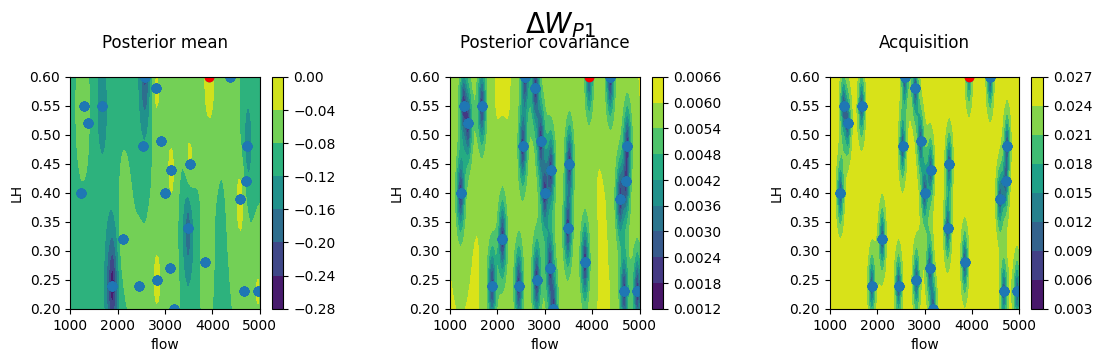

In [15]:
f = my_gp.posterior_mean(x_pred)["f(x)"]

f_cov = my_gp.posterior_covariance(x_pred, variance_only=False, add_noise=True)["v(x)"]

f_re = f.reshape(n_pts,n_pts)

f_cov_re = f_cov.reshape(n_pts,n_pts)

 # #Plot some results for tracking in each iteration:
title1 = "Posterior mean"
title2 = "Posterior covariance"
title3 = "Acquisition"
if is_this_a_test == 'y':
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_eval_Feb2025_P" + str(printer_number) + "_" + str(n_batch) + "_" + str(i) + "_test/"
else:
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_eval_Feb2025_P" + str(printer_number) + "_" + str(n_batch) + "_" + str(i) + "/"

if not os.path.exists(figurepath):
    # Create a new directory because it does not exist
    os.makedirs(figurepath)
    print("The new directory is created!")


if my_acq_func=="relative information entropy" or my_acq_func=="relative information entropy set" or my_acq_func=="total correlation":
    f_acq = my_gp.evaluate_acquisition_function(x_pred, acquisition_function=my_acq_func)
    
    tracking_contourplot_mean_cov(X, Y, f_re, f_cov_re, np.column_stack([points[:,0], points[:,1]]), 
                                      n_batch, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = f"$\\Delta W_{{P{printer_number}}}$")
    
else:
    f_acq = my_gp.evaluate_acquisition_function(x_pred, acquisition_function=my_acq_func)#, points_pred = np.zeros((len(points)*len(points),2)))
    
    f_acq_re = f_acq.reshape(n_pts, n_pts)
    
    tracking_contourplot_mean_cov_acq(X, Y, f_re, f_cov_re, f_acq_re, np.column_stack([points[:,0], points[:,1]]), 
                                          n_batch, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = f"$\\Delta W_{{P{printer_number}}}$")
    

### Save max acquistion function value

In [16]:
maxacq = max(my_gp.evaluate_acquisition_function(points, acquisition_function=my_acq_func))
print(maxacq)


0.013376161058523274


## 7. Save suggestions to file

In [17]:
point = points[-N_exp:]
# Run the loop
for i in range(len(point)):
    for rep_sim in [1, 2, 3]:
        #weight_columns = ['W_P1', 'W_P2', 'W_P3']
        weight_column = 'W_P1'#weight_columns[random_order[rep_sim - 1] - 1]

        new_row = {
            'Flow': round(point[i][0]),
            'LH': round(point[i][1], 2),
            'Rep_seq': printer_number,
            'Rep_sim': rep_sim,
            'W_P1': None,
            'W_P2': None,
            'W_P3': None
        }

        new_row[weight_column] = np.nan
        df.loc[len(df)] = new_row

print(df)

       Flow    LH  Rep_sim  Rep_seq   W_P1   W_P2   W_P3
0    3000.0  0.40        1        1  3.723  4.228  5.124
1    3000.0  0.40        2        1  3.848  4.170  4.999
2    3000.0  0.40        3        1  3.893  4.127  4.988
3    3000.0  0.40        1        2  3.801  4.128  5.299
4    3000.0  0.40        2        2  4.061  4.164  5.268
..      ...   ...      ...      ...    ...    ...    ...
223  3518.0  0.45        2        3  4.057  4.792  4.903
224  3518.0  0.45        3        3  3.897  4.609  4.873
225  3935.0  0.60        1        1    NaN    NaN    NaN
226  3935.0  0.60        2        1    NaN    NaN    NaN
227  3935.0  0.60        3        1    NaN    NaN    NaN

[228 rows x 7 columns]


/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_2669/865682798.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = new_row
/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_2669/865682798.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = new_row
/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_2669/865682798.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future ve

In [18]:
fname = "./data/data-experiment-Feb2025-P" + str(printer_number) + "_" +str(n_batch)+".csv"
if os.path.isfile(fname):
    save_data = input("There is already a document with that name, do you want to overwrite it? y/n")
    if save_data == 'y':
        df.to_csv(fname)
else:
    df.to_csv(fname)

There is already a document with that name, do you want to overwrite it? y/n n


### Save results to file

In [19]:
def write_results_to_file(x_pred, f_mean, f_cov, f_acq = None, filename=""):
    if f_acq:
        np.save(filename, np.column_stack([x_pred, f_mean, f_cov, f_acq]))
    else:
        np.save(filename, np.column_stack([x_pred, f_mean, f_cov]))

In [20]:
filename1 = 'Outputs/output_singleobject_Feb2025_P' + str(printer_number) + '_' + str(n_batch) + '.npy'

if isinstance(my_acq_func, str)==False:
    write_results_to_file(x_pred, f, f_cov_norm, f_acq = f_acq_norm, filename = filename1)
else:
    write_results_to_file(x_pred, f, f_cov, f_acq = None, filename = filename1)

## 8 Capture likelihood and hps output and save metadata

In [21]:
# Step 1: Capture the printed output
output_capture = io.StringIO()
print_capture = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture(*args, **kwargs, file=output_capture)

# Call the function and capture the output
print(my_gp.log_likelihood())

# Reset print to original function
print = print_capture

# Get the printed value as a string
captured_output = output_capture.getvalue().strip()


# Step 1: Capture the printed output
output_capture_hps = io.StringIO()
print_capture_hps = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture_hps(*args, **kwargs, file=output_capture_hps)

# Call the function and capture the output
print(my_gp.get_hyperparameters())

# Reset print to original function
print = print_capture_hps

# Get the printed value as a string
captured_output_hps = output_capture_hps.getvalue().strip()

In [22]:
# Example metadata
metadata = {
    "kernel": str(my_kernel), 
    "likelihood after BO after training": captured_output,
    "acqfunc": my_acq_func,
    "n_batch": n_batch,
    "n=1": "y",
    "gp training time stationary": time_,
    "hps after BO after training": captured_output_hps,
    "values": str(values[-N_exp:]),
    "maxacq": str(maxacq)
}

if not os.path.exists("./Metadata/"):
    # Create a new directory because it does not exist
    os.makedirs("./Metadata/")
    print("The new directory is created!")
    
# Save metadata to a YAML file
if is_this_a_test == 'y':
    metapath = "Metadata/metadata_after_BOP" + str(printer_number) + "_" + str(n_batch) + "_Feb2025"+"_test"+".yaml"
else: 
    metapath = "Metadata/metadata_after_BOP" + str(printer_number) + "_" + str(n_batch) + "_Feb2025.yaml"
with open(metapath, "w") as file:
    yaml.dump(metadata, file)